In [1]:
##%%timeit ##-n1 -r1 for one loop
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
 #loading images from directory
dataset=tf.keras.preprocessing.image_dataset_from_directory( 
    "../dataset/PlantVillage",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy(),"\n")  #each batch contains 32 images 

(32, 256, 256, 3)
[1 1 0 0 2 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1] 

(32, 256, 256, 3)
[2 1 0 2 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 2 0 1 0 0 1 0 1] 



In [6]:
#number of batches
len(dataset)

68

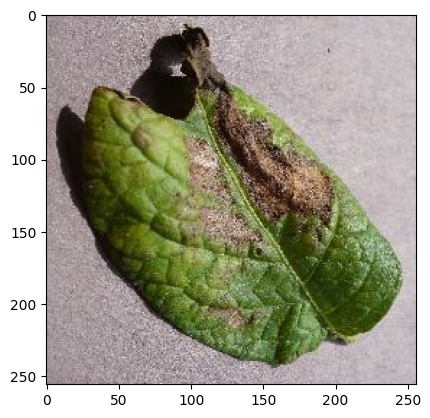

In [7]:
#print one image
iterator=iter(dataset)
first_element=next(iterator)
plt.imshow(first_element[0][0].numpy().astype('uint8'))

In [8]:
#first_element contains the 32 images and labels
len(first_element[0])

32

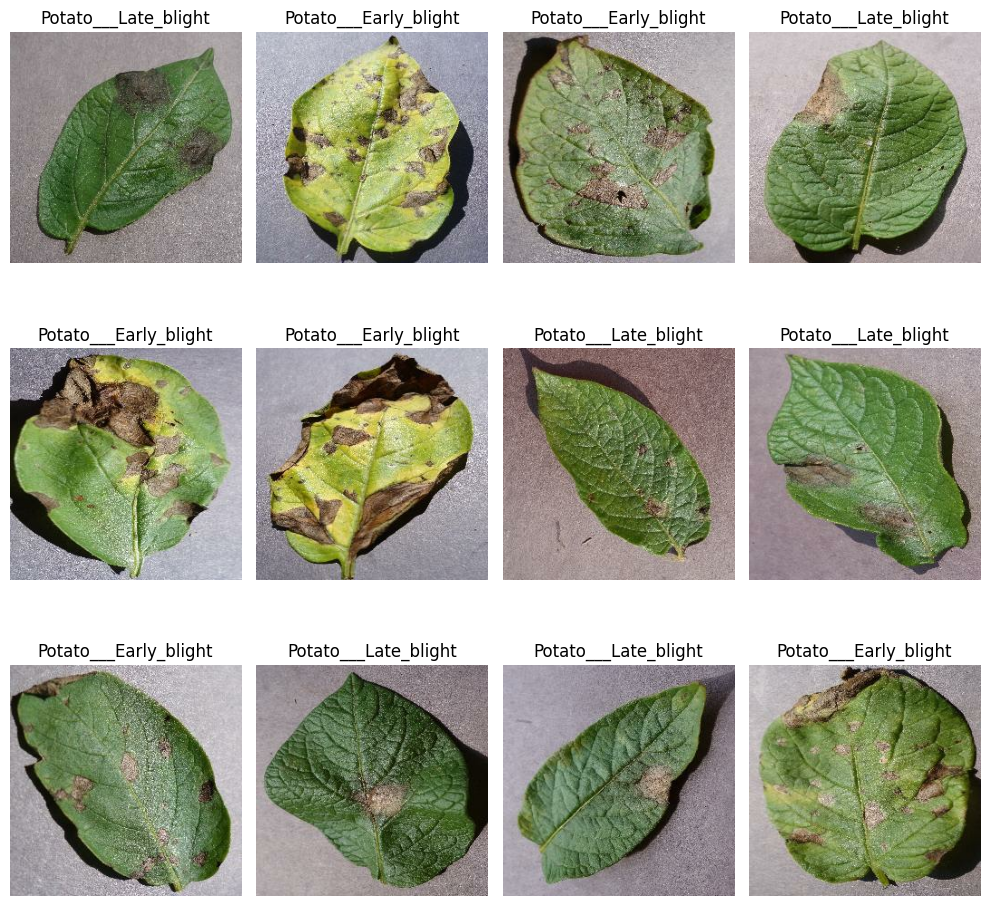

In [9]:
#display first 12 images of batch 1

plt.figure(figsize=(10,10))
for image_batch, image_label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[image_label[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

# Train Test Split

train => 80%

validation => 10%

test => 10%

In [10]:
TRAIN_SET=int(0.8*len(dataset))

TEST_SET=int(0.1*len(dataset))

VALIDATION_SET=len(dataset)-TRAIN_SET-TEST_SET

TRAIN_SET,TEST_SET,VALIDATION_SET

(54, 6, 8)

In [11]:
def get_dataset_partition(ds, train_split=0.8, test_split=0.1, validation_split=0.1, shuffle_size=10000):
    
    TRAIN_SET=int(0.8*len(dataset))
    TEST_SET=int(0.1*len(dataset))
    VALIDATION_SET=len(dataset)-TRAIN_SET-TEST_SET
    
    if shuffle_size:
        ds=ds.shuffle(shuffle_size, seed=11)
    
    train_ds= ds.take(TRAIN_SET)  #train dataset
    
    test_ds = ds.skip(TRAIN_SET).take(TEST_SET)  #test dataset
    
    validation_ds = ds.skip(TRAIN_SET).skip(TEST_SET)   #validation dataset
    
    return train_ds, test_ds, validation_ds

In [12]:
train_ds, test_ds, val_ds= get_dataset_partition(dataset)  #get train, test and validation dataset

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  #caching and prefetching
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing

In [14]:
#rescale and resizing layer

resize_and_rescale = tf.keras.Sequential([                     
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

# Model Building

In [16]:
n_classes=len(class_names)
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D(strides=(2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(strides=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(strides=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(strides=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(strides=(2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                  

In [18]:
model.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Setting GPU

In [19]:
#To check and use GPU for model training


gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True) #NOTE: replace gpus[0] according to your requirement
        print("GPU Configured: ",gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("no GPU!")
    print(tf.config.experimental.list_physical_devices('CPU'))

[]
no GPU!
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [20]:
EPOCHS=40

early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#model fitting
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    #callbacks=[early_stopping]
)

Epoch 1/40
54/54 [==============================] - 109s 2s/step - loss: 0.9213 - accuracy: 0.5123 - val_loss: 0.7946 - val_accuracy: 0.6992
Epoch 2/40
54/54 [==============================] - 101s 2s/step - loss: 0.6158 - accuracy: 0.7576 - val_loss: 0.5497 - val_accuracy: 0.7969
Epoch 3/40
54/54 [==============================] - 107s 2s/step - loss: 0.3088 - accuracy: 0.8727 - val_loss: 0.4672 - val_accuracy: 0.8320
Epoch 4/40
54/54 [==============================] - 102s 2s/step - loss: 0.3882 - accuracy: 0.8515 - val_loss: 0.2367 - val_accuracy: 0.9336
Epoch 5/40
54/54 [==============================] - 112s 2s/step - loss: 0.1734 - accuracy: 0.9296 - val_loss: 0.1332 - val_accuracy: 0.9609
Epoch 6/40
54/54 [==============================] - 104s 2s/step - loss: 0.1388 - accuracy: 0.9513 - val_loss: 0.0912 - val_accuracy: 0.9609
Epoch 7/40
54/54 [==============================] - 105s 2s/step - loss: 0.1673 - accuracy: 0.9366 - val_loss: 0.2411 - val_accuracy: 0.9062
Epoch 8/40
54

# Model evaluation

In [25]:
score = model.evaluate(test_ds)
score

6/6 [==============================] - 3s 524ms/step - loss: 0.2198 - accuracy: 0.9531


[0.2198103815317154, 0.953125]

In [26]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

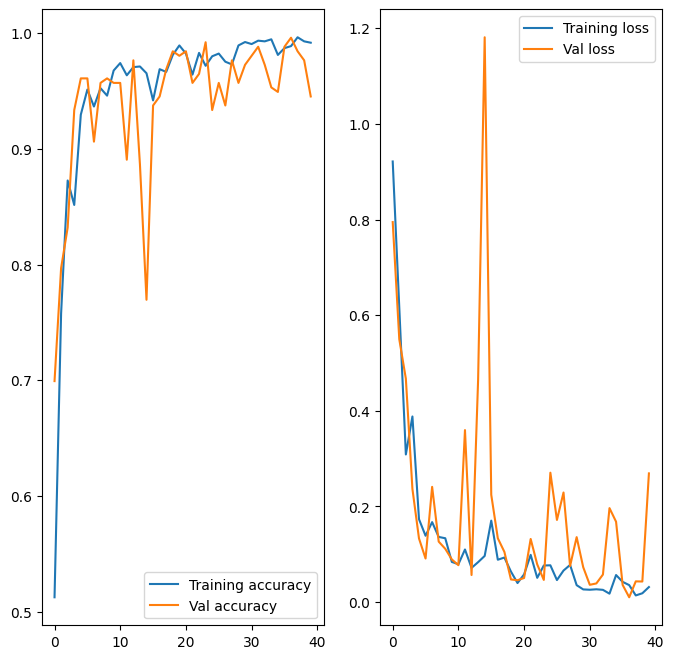

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training accuracy')
plt.plot(range(EPOCHS),val_acc, label='Val accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training loss')
plt.plot(range(EPOCHS),val_loss, label='Val loss')
plt.legend()

In [33]:
def predict(model, img):
    img_arr=tf.keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)  #to add 4th dimension (1, h,w,c)
    
    predictions = model.predict(img_arr)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 70ms/step


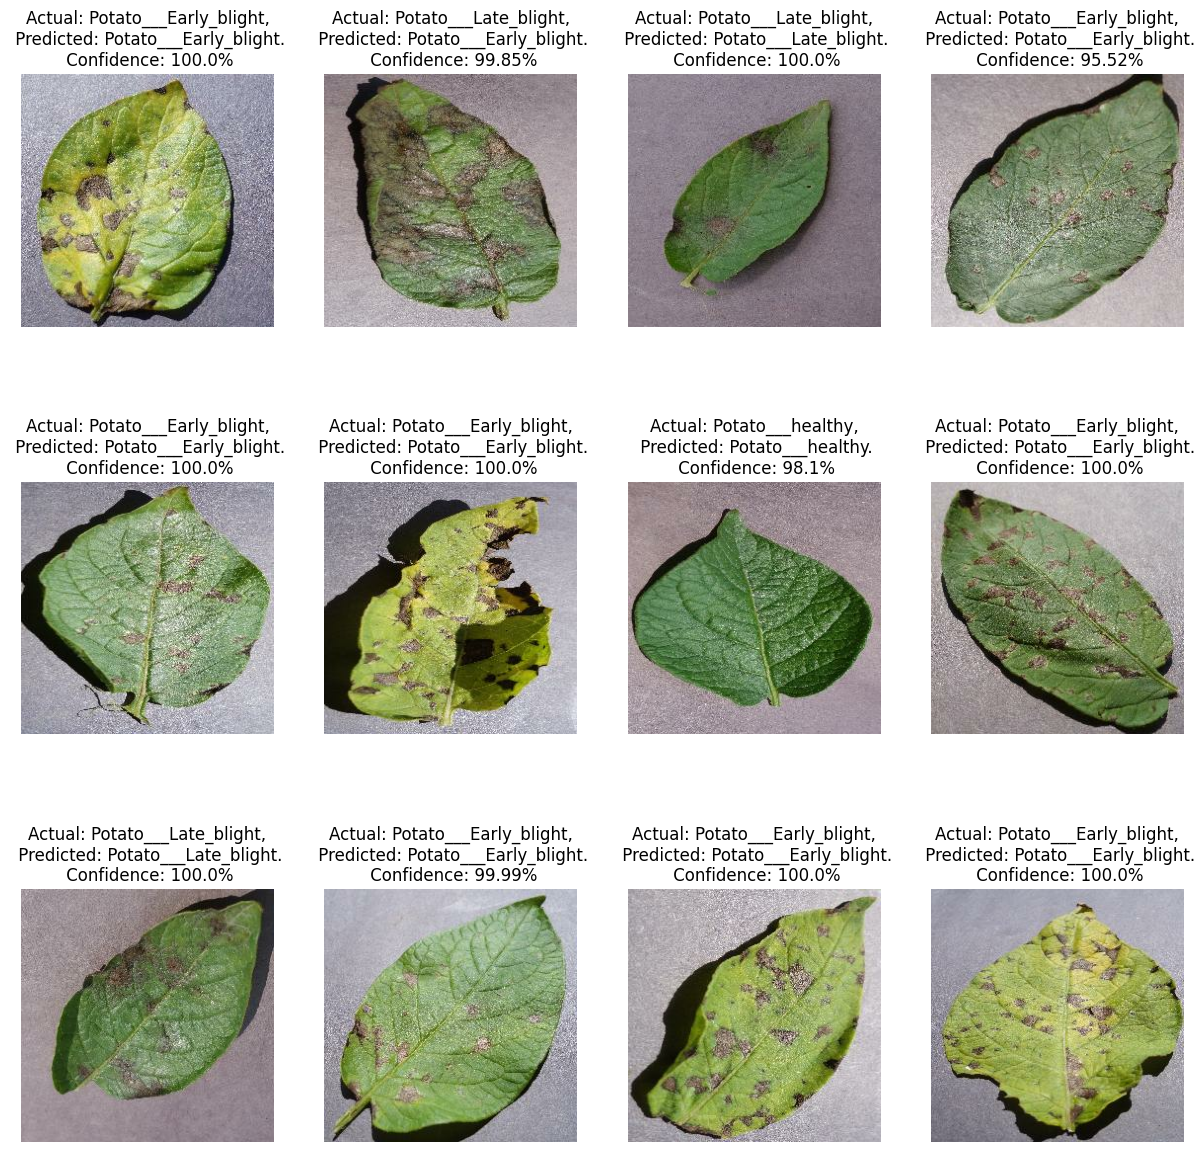

In [34]:
plt.figure(figsize=(15,15))
for image_batches , lable_batches in test_ds.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batches[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, image_batches[i].numpy())
        
        actual_class = class_names[lable_batches[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import os

latestVersion= max([int(folder)  for folder in os.listdir('../models')] +[0]) +1

model.save(f'../models/{latestVersion}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
